In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats
from scipy.special import stdtr
from scipy.stats import bartlett


In [2]:
df_d = pd.read_csv('Patient_Diagnosis.csv')
df_t = pd.read_csv("Patient_Treatment.csv")

In [16]:
df_d.describe()

,patient_id,diagnosis_code
count,57.000000,57.000000
mean,4898.649123,167.982456
std,2219.160165,9.903393
min,2038.000000,153.300000
25%,2770.000000,153.800000
50%,4256.000000,174.500000
75%,6889.000000,174.900000
max,9489.000000,174.900000


In [17]:
df_t.describe()

,patient_id
count,1096.000000
mean,5055.035584
std,2206.964675
min,2038.000000
25%,2763.000000
50%,4975.500000
75%,6840.000000
max,9489.000000


In [56]:
# number of distinct patients in diagnosis data
df_d['patient_id'].nunique()

47

In [55]:
# number of distinct patients in treatment data
df_t['patient_id'].nunique()

46

In [33]:
# convert date from string to date time data type
df_d['diagnosis_date'] = pd.to_datetime(df_d['diagnosis_date'])
df_t['treatment_date'] = pd.to_datetime(df_t['treatment_date'])

In [34]:
# distribution of cancer types
df_d.groupby(['diagnosis'])['patient_id'].nunique()

diagnosis
Breast Cancer    36
Colon Cancer     16
Name: patient_id, dtype: int64

In [206]:
# merge diagnosis and treatment data
df_all = pd.merge(df_d, df_t, how = 'left', on = 'patient_id')
# print size of all data
df_all.shape

(1239, 6)

In [58]:
# some patients have been diagnosed for 2 conditions, 
# thus we drop the rows where treatment is before diagnosis, which is supposed to be for the other diagnosis
df_all.drop(df_all[df_all['treatment_date'] < df_all['diagnosis_date']].index, inplace = True)

In [59]:
# treatment start date after diagnosis
df_treat_start = df_all.groupby(['diagnosis', 'patient_id'])['diagnosis_date', 'treatment_date'].agg(min)
df_treat_start.reset_index(drop = False, inplace = True)
# calculate lag from diagnosis to fist treatment
df_treat_start['lag'] = df_treat_start['treatment_date'] - df_treat_start['diagnosis_date']

In [101]:
# table of patients with corresponding first line drugs
df_start_drug = pd.merge(df_treat_start, df_all[['patient_id', 'treatment_date', 'drug_code']], 
                         how = 'left', on = ['patient_id', 'treatment_date']).drop_duplicates()
df_start_drug.sort_values(['diagnosis', 'patient_id', 'diagnosis_date', 'treatment_date', 'lag','drug_code'], ascending = True, inplace = True)
df_start_drug_grouped = df_start_drug.groupby(['diagnosis', 'patient_id', 'diagnosis_date', 
                                               'treatment_date', 'lag']).apply(lambda x: ', '.join(x['drug_code']))
df_start_drug_grouped = df_start_drug_grouped.reset_index(drop = False)
df_start_drug_grouped.rename({0:'First-line Drug'}, axis = 1, inplace = True)

In [127]:
# first line treatment for breast cancer
df_start_drug_grouped[df_start_drug_grouped['diagnosis'] == 'Breast Cancer']['First-line Drug'].value_counts(sort = True)

A, B    18
B        7
C        6
A        4
Name: First-line Drug, dtype: int64

In [128]:
# first line treatment for breast cancer
df_start_drug_grouped[df_start_drug_grouped['diagnosis'] == 'Colon Cancer']['First-line Drug'].value_counts(sort = True)

D       4
C       4
B       4
A, B    4
Name: First-line Drug, dtype: int64

In [125]:
# dataframe for all treatment and duration
df_treatment = df_all.groupby(['diagnosis', 'patient_id', 'diagnosis_date', 'drug_code'])['treatment_date'].agg([min, max])
df_treatment.reset_index(drop = False, inplace = True)
df_treatment['drug_start_lag'] = df_treatment['min'] - df_treatment['diagnosis_date']
df_treatment['drug_end_lag'] = df_treatment['max'] - df_treatment['diagnosis_date']
df_treatment['drug_duration'] = df_treatment['drug_end_lag'] - df_treatment['drug_start_lag']

In [129]:
# preview dataframe for breast cancer treatment
df_treatment[df_treatment['diagnosis'] == 'Breast Cancer'].sort_values(['drug_duration', 'drug_code','drug_start_lag', 'drug_end_lag'], ascending = False)

,diagnosis,patient_id,diagnosis_date,drug_code,min,max,drug_start_lag,drug_end_lag,drug_duration
0,Breast Cancer,2038,2010-01-21,A,2010-01-24,2017-02-20,3 days,2587 days,2584 days
6,Breast Cancer,2238,2010-01-21,B,2010-01-21,2012-10-18,0 days,1001 days,1001 days
44,Breast Cancer,6321,2012-09-06,C,2012-11-24,2013-03-08,79 days,183 days,104 days
41,Breast Cancer,6281,2012-08-12,C,2012-10-29,2013-02-05,78 days,177 days,99 days
38,Breast Cancer,5657,2012-06-07,C,2012-08-19,2012-11-26,73 days,172 days,99 days
35,Breast Cancer,5259,2012-05-13,C,2012-07-24,2012-10-30,72 days,170 days,98 days
32,Breast Cancer,4692,2012-04-27,C,2012-06-16,2012-09-21,50 days,147 days,97 days
59,Breast Cancer,9331,2013-08-23,A,2013-08-29,2013-12-02,6 days,101 days,95 days
61,Breast Cancer,9331,2013-08-23,C,2013-12-09,2014-03-11,108 days,200 days,92 days
22,Breast Cancer,3757,2011-10-11,C,2011-10-22,2012-01-17,11 days,98 days,87 days


In [130]:
# check treatment history for patient 2038
df_t[df_t['patient_id'] == 2038]

,patient_id,treatment_date,drug_code
3,2038,2010-01-24,A
5,2038,2010-01-24,B
8,2038,2010-01-27,A
9,2038,2010-01-27,B
15,2038,2010-01-30,A
16,2038,2010-01-30,B
20,2038,2010-02-02,A
24,2038,2010-02-06,A
31,2038,2010-02-11,A
45,2038,2010-02-18,A


In [131]:
# check treatment history for patient 2238
df_t[df_t['patient_id'] == 2238]

,patient_id,treatment_date,drug_code
1,2238,2010-01-21,B
17,2238,2010-01-31,B
29,2238,2010-02-10,B
50,2238,2010-02-20,B
64,2238,2010-03-02,B
70,2238,2010-03-12,B
78,2238,2010-03-22,B
84,2238,2010-04-01,B
631,2238,2012-09-18,B
649,2238,2012-09-28,B


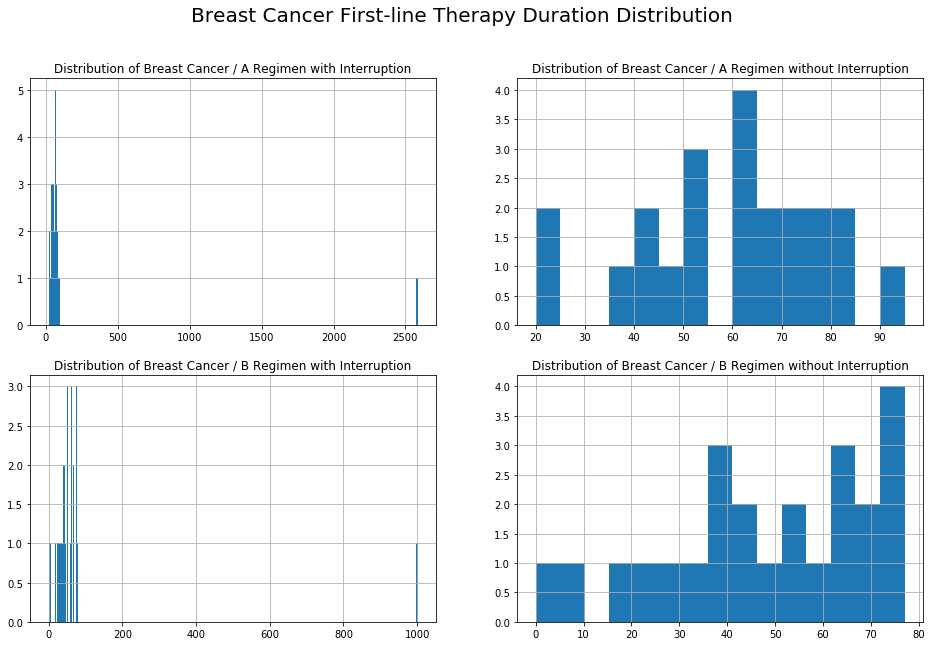

In [189]:
# plot distribution for breast cancer first line treatment (Regimen A and Regimen B) duration
plt.clf()
plt.figure(figsize=(16,10))
plt.suptitle('Breast Cancer First-line Therapy Duration Distribution', fontsize = 20)
# distribution of A / Breast Cancer with interruption
plt.subplot(2,2,1)
df_treatment[(df_treatment['diagnosis'] == 'Breast Cancer') & (df_treatment['drug_code'] == 'A')]['drug_duration'].dt.days.hist(bins = 300).set_title('Distribution of Breast Cancer / A Regimen with Interruption')
# distribution of A / Breast Cancer without interruption
plt.subplot(2,2,2)
df_treatment[(df_treatment['diagnosis'] == 'Breast Cancer') & (df_treatment['drug_code'] == 'A') & (df_treatment['drug_duration'].dt.days < 500)]['drug_duration'].dt.days.hist(bins = 15).set_title('Distribution of Breast Cancer / A Regimen without Interruption')
# distribution of B / Breast Cancer with interruption
plt.subplot(2,2,3)
df_treatment[(df_treatment['diagnosis'] == 'Breast Cancer') & (df_treatment['drug_code'] == 'B')]['drug_duration'].dt.days.hist(bins = 300).set_title('Distribution of Breast Cancer / B Regimen with Interruption')
# distribution of A / Breast Cancer without interruption
plt.subplot(2,2,4)
df_treatment[(df_treatment['diagnosis'] == 'Breast Cancer') & (df_treatment['drug_code'] == 'B') & (df_treatment['drug_duration'].dt.days < 500)]['drug_duration'].dt.days.hist(bins = 15).set_title('Distribution of Breast Cancer / B Regimen without Interruption')
plt.show()

In [190]:
# get 2 samples for regimen A and regimen B
df_a_regimen = df_treatment[(df_treatment['diagnosis'] == 'Breast Cancer') & (df_treatment['drug_code'] == 'A')]['drug_duration'].dt.days
df_b_regimen = df_treatment[(df_treatment['diagnosis'] == 'Breast Cancer') & (df_treatment['drug_code'] == 'B')]['drug_duration'].dt.days

In [201]:
# Function to test if A and B regimen have same variance of duration
# assumption: normal distribution
# bartlett's test on H0: Var A = Var B, H1: Var A != Var B
def bartlett_test(a,b):
    t2, p2 = bartlett([a,b])
    print('bartlett test result: t = %g  p = %g' % (t2, p2))

In [203]:
# execute bartlett test:
bartlett(df_a_regimen, df_b_regimen)

BartlettResult(statistic=20.344389054413032, pvalue=6.468247809845421e-06)

In [204]:
# Function to test if A and B regimen have same mean of duration
# assumption: homoscedasticity, normal distribution, different variance
# t test on H0: Mean A = Mean B, H1: Mean A != Mean B
def t_test(a,b):
    # Compute the descriptive statistics of a and b.
    abar = a.mean()
    avar = a.var(ddof=1)
    na = a.size
    adof = na - 1

    bbar = b.mean()
    bvar = b.var(ddof=1)
    nb = b.size
    bdof = nb - 1

    # Use scipy.stats.ttest_ind_from_stats.
    t1, p1 = ttest_ind_from_stats(abar, np.sqrt(avar), na,
                                  bbar, np.sqrt(bvar), nb,
                                  equal_var=False)
    print('t test result: t = %g  p = %g' % (t1, p1))

In [205]:
# execute t test:
t_test(df_a_regimen, df_b_regimen)

t test result: t = 0.710007  p = 0.483717
